In [1]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

from torch.distributions.normal import Normal

import matplotlib.pyplot as plt

from torch.optim import Adam
import torch.optim as optim
from torch.utils.data import DataLoader

import os

import argparse as args
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from torch.autograd import Function

In [2]:
# hyper parameter
BATCH_SIZE = 32  #each batch's input figures
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 4 # the rounds of dataset training 

MNIST

In [4]:
# pipeline adjust the input figure
pipeline = transforms.Compose([
    transforms.ToTensor(),  #transfer figures to tensor
    transforms.Normalize((0.1307,), (0.3081,))  #regularization
])

# download dataset
from torch.utils.data import DataLoader
#download dataset   raw data
train_set= datasets.MNIST("data", train=True,  download=True, transform=pipeline)
test_set= datasets.MNIST("data", train=False,  download=True, transform=pipeline)
#load dataset   separate to different batches
train_data = DataLoader(train_set, batch_size= BATCH_SIZE, shuffle=True)
test_data = DataLoader(test_set, batch_size = BATCH_SIZE, shuffle=True)

Cifar10

In [7]:
# preprocess，minus cifar-10 average
pipeline_cifar10 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))
])
# data enhancement
transform_aug = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# 
cifar10_train_set = datasets.CIFAR10('../DATA/dataset_cifar10', train=True, download=True, transform=pipeline_cifar10)
cifar10_train_data = DataLoader(cifar10_train_set, batch_size=BATCH_SIZE, shuffle=True)
# 
cifar10_test_set = datasets.CIFAR10('../DATA/dataset_cifar10', train=False, download=True, transform=pipeline_cifar10)
cifar10_test_data = DataLoader(cifar10_test_set, batch_size=BATCH_SIZE)
batchLen = len(cifar10_train_data)          #batch_number
digitsBatchLen = len(str(batchLen))

Files already downloaded and verified
Files already downloaded and verified


MODEL

In [16]:
class LeNet5_MNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6,kernel_size=5,stride=1,padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    def forward(self, x):
        #print("input:", x.size())
        x = F.relu(self.conv1(x))
        #print("After conv1:", x.size())
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16*5*5) # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        output = F.log_softmax(x,dim=1) #

        return output
    
class LeNet5_CIFAR_10(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6,kernel_size=5,stride=1,padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    def forward(self, x):
        #print("input:", x.size())
        x = F.relu(self.conv1(x))
        #print("After conv1:", x.size())
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16*5*5) # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        output = F.log_softmax(x,dim=1) #

        return output

In [13]:
# choose optimizer
FC_NN_model = LeNet5_MNIST().to(DEVICE)

optimizer = optim.Adam(FC_NN_model.parameters())

In [18]:
# # # training
# # def train_model(model, device, train_data, optimizer, epoch):
#     model.train()
#     for batch_index, (data , target) in enumerate(train_data):  # tran by batch
#         data, target = data.to(device), target.to(device)
#         #initialize gradient
#         optimizer.zero_grad()
#         #training result
#         output = model(data)
#         #loss function      cross_entropy used for classification
#         loss = F.nll_loss(output, target)
#         #backpropagation
#         loss.backward()
#         #update parameters
#         optimizer.step()
#         #print loss
#         if batch_index % 3000 ==0:
#             print("Train Epoch : {} \t Loss : {:.6f}".format(epoch, loss.item()))

In [ ]:
# # result
# for epoch in range(1, EPOCHS + 1):
#     train_model(FC_NN_model, DEVICE, train_data, optimizer, epoch)
#     test_model(FC_NN_model, DEVICE, test_data)

In [10]:
# test
def test_model(model , device, test_data):
        #model verify
        model.eval()
        #accuracy
        correct = 0.0
        #test loss
        test_loss = 0.0
        with torch.no_grad():
                for data, target in test_data:
                        data, target = data.to(device), target.to(device)
                        #output
                        output = model(data)
                        #loss 
                        test_loss +=F.nll_loss(output, target).item()
                        #find the index of the most likelihood label
                        pred = output.max(1, keepdim=True)[1] #0：value 1:index
                        #pred = output.argmax(dim=1)
                        
                        # correct numbers
                        correct += pred.eq(target.view_as(pred)).sum().item()
                test_loss /= len(test_data.dataset)
                print("Test--average loss: {:.4f}, accuracy: {:.3f}\n".format(test_loss, 100.0 * correct / len(test_data.dataset)))


In [ ]:
# Save model parameters
# torch.save(FC_NN_model.state_dict(), 'parameters_FC_NN.pth')

FULL ACCURACY

MNIST

In [14]:
FC_NN_model = LeNet5_MNIST().to(DEVICE)
# load the parameters
FC_NN_model.load_state_dict(torch.load('LeNet5_MNIST.pth'))

# test
FC_NN_model.eval()
test_model(FC_NN_model, DEVICE, test_data)

Test--average loss: 0.0012, accuracy: 99.050



CIFAR_10

In [17]:
FC_NN_model = LeNet5_CIFAR_10().to(DEVICE)
# load the parameters
FC_NN_model.load_state_dict(torch.load('LeNet5_CIFAR10.pth'))

# test
FC_NN_model.eval()
test_model(FC_NN_model, DEVICE, cifar10_test_data)

Test--average loss: 0.0274, accuracy: 69.670



Quantization

In [18]:
class FakeQuantize(Function):

    @staticmethod
    def forward(ctx, x, qparam):
        x = qparam.quantize_tensor(x)
        x = qparam.dequantize_tensor(x)
        return x

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output, None
    

In [28]:
def calcScaleZeroPoint(min_val, max_val, num_bits=8):
    qmin = 0.
    qmax = 2. ** num_bits - 1.
    scale = (max_val - min_val) / (qmax - qmin)

    zero_point = qmax - max_val / scale

    if zero_point < qmin:
        zero_point = torch.tensor([qmin], dtype=torch.float32).to(min_val.device)
    elif zero_point > qmax:
        # zero_point = qmax
        zero_point = torch.tensor([qmax], dtype=torch.float32).to(max_val.device)
    
    zero_point.round_()

    return scale, zero_point

def quantize_tensor(x, scale, zero_point, num_bits=8, signed=False):
    if signed:
        qmin = - 2. ** (num_bits - 1)
        qmax = 2. ** (num_bits - 1) - 1
    else:
        qmin = 0.
        qmax = 2. ** num_bits - 1.
 
    q_x = zero_point + x / scale
    q_x.clamp_(qmin, qmax).round_()
    
    return q_x
 
def dequantize_tensor(q_x, scale, zero_point):
    return scale * (q_x - zero_point)

class QParam(nn.Module):

    def __init__(self, num_bits=8):
        super(QParam, self).__init__()
        self.num_bits = num_bits
        scale = torch.tensor([], requires_grad=False)
        zero_point = torch.tensor([], requires_grad=False)
        min = torch.tensor([], requires_grad=False)
        max = torch.tensor([], requires_grad=False)
        self.register_buffer('scale', scale)
        self.register_buffer('zero_point', zero_point)
        self.register_buffer('min', min)
        self.register_buffer('max', max)

    def update(self, tensor):
        if self.max.nelement() == 0 or self.max.data < tensor.max().data:
            self.max.data = tensor.max().data
            # self.max.data = torch.quantile(tensor, 0.98)
        self.max.clamp_(min=0)
        
        if self.min.nelement() == 0 or self.min.data > tensor.min().data:
            self.min.data = tensor.min().data
            # self.min.data = torch.quantile(tensor, 0.02)
        self.min.clamp_(max=0)
        
        self.scale, self.zero_point = calcScaleZeroPoint(self.min, self.max, self.num_bits)
    
    def quantize_tensor(self, tensor):
        return quantize_tensor(tensor, self.scale, self.zero_point, num_bits=self.num_bits)

    def dequantize_tensor(self, q_x):
        return dequantize_tensor(q_x, self.scale, self.zero_point)

    def _load_from_state_dict(self, state_dict, prefix, local_metadata, strict, missing_keys, unexpected_keys, error_msgs):
        key_names = ['scale', 'zero_point', 'min', 'max']
        for key in key_names:
            value = getattr(self, key)
            value.data = state_dict[prefix + key].data
            state_dict.pop(prefix + key)

    def __str__(self):
        info = 'scale: %.10f ' % self.scale
        info += 'zp: %d ' % self.zero_point
        info += 'min: %.6f ' % self.min
        info += 'max: %.6f' % self.max
        return info

class QModule(nn.Module):

    def __init__(self, qi=True, qo=True, num_bits=8):
        super(QModule, self).__init__()
        if qi:
            self.qi = QParam(num_bits=num_bits)
        if qo:
            self.qo = QParam(num_bits=num_bits)

    def freeze(self):
        pass

    def quantize_inference(self, x):
        raise NotImplementedError('quantize_inference should be implemented.')
    
class QLinear(QModule):

    def __init__(self, fc_module, qi=True, qo=True, num_bits=8):
        super(QLinear, self).__init__(qi=qi, qo=qo, num_bits=num_bits)
        self.num_bits = num_bits
        self.fc_module = fc_module
        self.qw = QParam(num_bits=num_bits)
        self.register_buffer('M', torch.tensor([], requires_grad=False))  

    def freeze(self, qi=None, qo=None):

        if hasattr(self, 'qi') and qi is not None:
            raise ValueError('qi has been provided in init function.')
        if not hasattr(self, 'qi') and qi is None:
            raise ValueError('qi is not existed, should be provided.')

        if hasattr(self, 'qo') and qo is not None:
            raise ValueError('qo has been provided in init function.')
        if not hasattr(self, 'qo') and qo is None:
            raise ValueError('qo is not existed, should be provided.')

        if qi is not None:
            self.qi = qi
        if qo is not None:
            self.qo = qo
        self.M.data = (self.qw.scale * self.qi.scale / self.qo.scale).data

        self.fc_module.weight.data = self.qw.quantize_tensor(self.fc_module.weight.data)
        self.fc_module.weight.data = self.fc_module.weight.data - self.qw.zero_point
        self.fc_module.bias.data = quantize_tensor(self.fc_module.bias.data, scale=self.qi.scale * self.qw.scale,
                                                   zero_point=0, num_bits=32, signed=True)

    def forward(self, x):
        if hasattr(self, 'qi'):
            self.qi.update(x)
            x = FakeQuantize.apply(x, self.qi)

        self.qw.update(self.fc_module.weight.data)

        x = F.linear(x, FakeQuantize.apply(self.fc_module.weight, self.qw), self.fc_module.bias)

        if hasattr(self, 'qo'):
            self.qo.update(x)
            x = FakeQuantize.apply(x, self.qo)

        return x

    def quantize_inference(self, x):
        x = x - self.qi.zero_point
        x = self.fc_module(x)
        x = self.M * x
        x.round_() 
        x = x + self.qo.zero_point
        x.clamp_(0., 2.**self.num_bits-1.).round_()
        return x

class QReLU(QModule):

    def __init__(self, qi=False, num_bits=None):
        super(QReLU, self).__init__(qi=qi, num_bits=num_bits)

    def freeze(self, qi=None):
        
        if hasattr(self, 'qi') and qi is not None:
            raise ValueError('qi has been provided in init function.')
        if not hasattr(self, 'qi') and qi is None:
            raise ValueError('qi is not existed, should be provided.')

        if qi is not None:
            self.qi = qi

    def forward(self, x):
        if hasattr(self, 'qi'):
            self.qi.update(x)
            x = FakeQuantize.apply(x, self.qi)

        x = F.relu(x)

        return x
    
    def quantize_inference(self, x):
        x = x.clone()
        x[x < self.qi.zero_point] = self.qi.zero_point
        return x

class QMaxPooling2d(QModule):

    def __init__(self, kernel_size=3, stride=1, padding=0, qi=False, num_bits=None):
        super(QMaxPooling2d, self).__init__(qi=qi, num_bits=num_bits)
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def freeze(self, qi=None):
        if hasattr(self, 'qi') and qi is not None:
            raise ValueError('qi has been provided in init function.')
        if not hasattr(self, 'qi') and qi is None:
            raise ValueError('qi is not existed, should be provided.')
        if qi is not None:
            self.qi = qi

    def forward(self, x):
        if hasattr(self, 'qi'):
            self.qi.update(x)
            x = FakeQuantize.apply(x, self.qi)

        x = F.max_pool2d(x, self.kernel_size, self.stride, self.padding)

        return x

    def quantize_inference(self, x):
        return F.max_pool2d(x, self.kernel_size, self.stride, self.padding)
    
class QSigmoid(QModule):

    def __init__(self, qi=True, qo=True, num_bits=8, lut_size=64):
        super(QSigmoid, self).__init__(qi=qi, qo=qo, num_bits=num_bits)
        self.num_bits = num_bits
        self.lut_size = lut_size
    
    def forward(self, x):
        if hasattr(self, 'qi'):
            self.qi.update(x)
            x = FakeQuantize.apply(x, self.qi)

        x = torch.sigmoid(x)

        if hasattr(self, 'qo'):
            self.qo.update(x)
            x = FakeQuantize.apply(x, self.qo)

        return x
    
    def freeze(self, qi=None, qo=None):
        if hasattr(self, 'qi') and qi is not None:
            raise ValueError('qi has been provided in init function.')
        if not hasattr(self, 'qi') and qi is None:
            raise ValueError('qi is not existed, should be provided.')

        if hasattr(self, 'qo') and qo is not None:
            raise ValueError('qo has been provided in init function.')
        if not hasattr(self, 'qo') and qo is None:
            raise ValueError('qo is not existed, should be provided.')

        if qi is not None:
            self.qi = qi
        if qo is not None:
            self.qo = qo

        lut_qx = torch.tensor(np.linspace(0, 2 ** self.num_bits - 1, self.lut_size), dtype=torch.uint8)
        lut_x = self.qi.dequantize_tensor(lut_qx)
        lut_y = torch.sigmoid(lut_x)
        lut_qy = self.qo.quantize_tensor(lut_y)

        self.register_buffer('lut_qy', lut_qy)
        self.register_buffer('lut_qx', lut_qx)


    def quantize_inference(self, x):
        y = interp(x, self.lut_qx, self.lut_qy)
        y = y.round_().clamp_(0., 2.**self.num_bits-1.)
        return y

class QConv2d(QModule):

    def __init__(self, conv_module, qi=True, qo=True, num_bits=8):
        super(QConv2d, self).__init__(qi=qi, qo=qo, num_bits=num_bits)
        self.num_bits = num_bits
        self.conv_module = conv_module
        self.qw = QParam(num_bits=num_bits)
        self.register_buffer('M', torch.tensor([], requires_grad=False))  # register M as buffer

    def freeze(self, qi=None, qo=None):
        
        if hasattr(self, 'qi') and qi is not None:
            raise ValueError('qi has been provided in init function.')
        if not hasattr(self, 'qi') and qi is None:
            raise ValueError('qi is not existed, should be provided.')

        if hasattr(self, 'qo') and qo is not None:
            raise ValueError('qo has been provided in init function.')
        if not hasattr(self, 'qo') and qo is None:
            raise ValueError('qo is not existed, should be provided.')

        if qi is not None:
            self.qi = qi
        if qo is not None:
            self.qo = qo
        self.M.data = (self.qw.scale * self.qi.scale / self.qo.scale).data

        self.conv_module.weight.data = self.qw.quantize_tensor(self.conv_module.weight.data)
        self.conv_module.weight.data = self.conv_module.weight.data - self.qw.zero_point

        self.conv_module.bias.data = quantize_tensor(self.conv_module.bias.data, scale=self.qi.scale * self.qw.scale,
                                                     zero_point=0, num_bits=32, signed=True)

    def forward(self, x):
        if hasattr(self, 'qi'):
            self.qi.update(x)
            x = FakeQuantize.apply(x, self.qi)

        self.qw.update(self.conv_module.weight.data)

        x = F.conv2d(x, FakeQuantize.apply(self.conv_module.weight, self.qw), self.conv_module.bias, 
                     stride=self.conv_module.stride,
                     padding=self.conv_module.padding, dilation=self.conv_module.dilation, 
                     groups=self.conv_module.groups)

        if hasattr(self, 'qo'):
            self.qo.update(x)
            x = FakeQuantize.apply(x, self.qo)

        return x

    def quantize_inference(self, x):
        x = x - self.qi.zero_point
        x = self.conv_module(x)
        x = self.M * x
        x.round_() 
        x = x + self.qo.zero_point        
        x.clamp_(0., 2.**self.num_bits-1.).round_()
        return x

QUANTIZATION NMODEL

In [70]:
class QLeNet5_CIFAR_10(nn.Module):

    def __init__(self, num_channels=1):
        super(QLeNet5_CIFAR_10, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6,kernel_size=5,stride=1,padding=0)
        #self.bn1 = nn.BatchNorm2d(6)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        #self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)

        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    def forward(self, x):
        #print("input:", x.size())
        x = self.conv1(x)
        #x = self.bn1(x)
        x = F.relu(x)
        #print("After conv1:", x.size())
        x = self.pool1(x)

        x = self.conv2(x)
        #x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = x.view(-1, 16*5*5) # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #x = self.fc1(x)
        
        output = F.log_softmax(x,dim=1) #

        return x

    def quantize(self, num_bits=8):
        self.qconv1 = QConv2d(self.conv1, qi=True, qo=True, num_bits=num_bits)
        self.qrelu1 = QReLU()
        self.qmaxpool2d_1 = QMaxPooling2d(kernel_size=2, stride=2, padding=0)

        self.qconv2 = QConv2d(self.conv2, qi=False, qo=True, num_bits=num_bits)
        self.qrelu2 = QReLU()
        self.qmaxpool2d_2 = QMaxPooling2d(kernel_size=2, stride=2, padding=0)

        self.qfc1 = QLinear(self.fc1, qi=False, qo=True, num_bits=num_bits)
        self.qrelu3 = QReLU()
        self.qfc2 = QLinear(self.fc2, qi=False, qo=True, num_bits=num_bits)
        self.qrelu4 = QReLU()
        self.qfc3 = QLinear(self.fc3, qi=False, qo=True, num_bits=num_bits)

    def quantize_forward(self, x):
        x = self.qconv1(x)
        x = self.qrelu1(x)
        x = self.qmaxpool2d_1(x)

        x = self.qconv2(x)
        x = self.qrelu2(x)
        x = self.qmaxpool2d_2(x)

        x = x.view(-1, 16*5*5)
        x = self.qfc1(x)
        x = self.qrelu3(x)

        x = self.qfc2(x)
        x = self.qrelu4(x)
        
        x = self.qfc3(x)
        return x

    def freeze(self):
        self.qconv1.freeze()
        self.qrelu1.freeze(self.qconv1.qo)
        self.qmaxpool2d_1.freeze(self.qconv1.qo)

        self.qconv2.freeze(qi=self.qconv1.qo)
        self.qrelu2.freeze(self.qconv2.qo)
        self.qmaxpool2d_2.freeze(self.qconv2.qo)

        self.qfc1.freeze(qi=self.qconv2.qo)
        self.qrelu3.freeze(self.qfc1.qo)
        self.qfc2.freeze(qi=self.qfc1.qo)
        self.qrelu4.freeze(self.qfc2.qo)
        self.qfc3.freeze(qi=self.qfc2.qo)

    def quantize_inference(self, x):
        qx = self.qconv1.qi.quantize_tensor(x)
        qx = self.qconv1.quantize_inference(qx)
        qx = self.qrelu1.quantize_inference(qx)
        qx = self.qmaxpool2d_1.quantize_inference(qx)

        qx = self.qconv2.quantize_inference(qx)
        qx = self.qrelu2.quantize_inference(qx)
        qx = self.qmaxpool2d_2.quantize_inference(qx)

        qx = qx.view(-1, 16*5*5)
        qx = self.qfc1.quantize_inference(qx)
        qx = self.qrelu3.quantize_inference(qx)
        qx = self.qfc2.quantize_inference(qx)
        qx = self.qrelu4.quantize_inference(qx)
        qx = self.qfc3.quantize_inference(qx)
        
        out = self.qfc3.qo.dequantize_tensor(qx)
        #out = F.log_softmax(out,dim=1)
        return out


class QLeNet5_MNIST(nn.Module):

    def __init__(self, num_channels=1):
        super(QLeNet5_MNIST, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6,kernel_size=5,stride=1,padding=2)
        #self.bn1 = nn.BatchNorm2d(6)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        #self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)

        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    def forward(self, x):
        #print("input:", x.size())
        x = self.conv1(x)
        #x = self.bn1(x)
        x = F.relu(x)
        #print("After conv1:", x.size())
        x = self.pool1(x)

        x = self.conv2(x)
        #x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = x.view(-1, 16*5*5) # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #x = self.fc1(x)
        
        output = F.log_softmax(x,dim=1) #

        return x

    def quantize(self, num_bits=8):
        self.qconv1 = QConv2d(self.conv1, qi=True, qo=True, num_bits=num_bits)
        self.qrelu1 = QReLU()
        self.qmaxpool2d_1 = QMaxPooling2d(kernel_size=2, stride=2, padding=0)

        self.qconv2 = QConv2d(self.conv2, qi=False, qo=True, num_bits=num_bits)
        self.qrelu2 = QReLU()
        self.qmaxpool2d_2 = QMaxPooling2d(kernel_size=2, stride=2, padding=0)

        self.qfc1 = QLinear(self.fc1, qi=False, qo=True, num_bits=num_bits)
        self.qrelu3 = QReLU()
        self.qfc2 = QLinear(self.fc2, qi=False, qo=True, num_bits=num_bits)
        self.qrelu4 = QReLU()
        self.qfc3 = QLinear(self.fc3, qi=False, qo=True, num_bits=num_bits)

    def quantize_forward(self, x):
        x = self.qconv1(x)
        x = self.qrelu1(x)
        x = self.qmaxpool2d_1(x)

        x = self.qconv2(x)
        x = self.qrelu2(x)
        x = self.qmaxpool2d_2(x)

        x = x.view(-1, 16*5*5)
        x = self.qfc1(x)
        x = self.qrelu3(x)

        x = self.qfc2(x)
        x = self.qrelu4(x)
        
        x = self.qfc3(x)
        return x

    def freeze(self):
        self.qconv1.freeze()
        self.qrelu1.freeze(self.qconv1.qo)
        self.qmaxpool2d_1.freeze(self.qconv1.qo)

        self.qconv2.freeze(qi=self.qconv1.qo)
        self.qrelu2.freeze(self.qconv2.qo)
        self.qmaxpool2d_2.freeze(self.qconv2.qo)

        self.qfc1.freeze(qi=self.qconv2.qo)
        self.qrelu3.freeze(self.qfc1.qo)
        self.qfc2.freeze(qi=self.qfc1.qo)
        self.qrelu4.freeze(self.qfc2.qo)
        self.qfc3.freeze(qi=self.qfc2.qo)

    def quantize_inference(self, x):
        qx = self.qconv1.qi.quantize_tensor(x)
        qx = self.qconv1.quantize_inference(qx)
        qx = self.qrelu1.quantize_inference(qx)
        qx = self.qmaxpool2d_1.quantize_inference(qx)

        qx = self.qconv2.quantize_inference(qx)
        qx = self.qrelu2.quantize_inference(qx)
        qx = self.qmaxpool2d_2.quantize_inference(qx)

        qx = qx.view(-1, 16*5*5)
        qx = self.qfc1.quantize_inference(qx)
        qx = self.qrelu3.quantize_inference(qx)
        qx = self.qfc2.quantize_inference(qx)
        qx = self.qrelu4.quantize_inference(qx)
        qx = self.qfc3.quantize_inference(qx)
        
        out = self.qfc3.qo.dequantize_tensor(qx)
        #out = F.log_softmax(out,dim=1)
        return out


In [71]:
def direct_quantize(model, test_loader):
    for i, (data, target) in enumerate(test_loader, 1):
        output = model.quantize_forward(data)
        if i % 500 == 0:
            break
    print('direct quantization finish')


def full_inference(model, test_loader):
    correct = 0
    for i, (data, target) in enumerate(test_loader, 1):
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    print('\nTest set: Full Model Accuracy: {:.0f}%\n'.format(100. * correct / len(test_loader.dataset)))


def quantize_inference(model, test_loader):
    correct = 0
    for i, (data, target) in enumerate(test_loader, 1):
        output = model.quantize_inference(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    print('\nTest set: Quant Model Accuracy: {:.0f}%\n'.format(100. * correct / len(test_loader.dataset)))
    return (100. * correct / len(test_loader.dataset))

CIFAR-10

In [72]:
save_model = QLeNet5_CIFAR_10()
# load the parameters
save_model.load_state_dict(torch.load('LeNet5_CIFAR10.pth'))

save_model.eval()
full_inference(save_model, cifar10_test_data)

num_bits = 4
save_model.quantize(num_bits=num_bits)
save_model.eval()
print('Quantization bit: %d' % num_bits)

direct_quantize(save_model, cifar10_train_data)
save_model.freeze()
quantize_inference(save_model, cifar10_test_data)


Test set: Full Model Accuracy: 70%

Quantization bit: 4
direct quantization finish

Test set: Quant Model Accuracy: 46%



45.79


Test set: Full Model Accuracy: 70%

Quantization bit: 1
direct quantization finish

Test set: Quant Model Accuracy: 10%

Full Model Accuracy: None%
Quantized Model Accuracy (1-bit): 10.0%


Test set: Full Model Accuracy: 70%

Quantization bit: 2
direct quantization finish

Test set: Quant Model Accuracy: 10%

Full Model Accuracy: None%
Quantized Model Accuracy (2-bit): 9.98%


Test set: Full Model Accuracy: 70%

Quantization bit: 3
direct quantization finish

Test set: Quant Model Accuracy: 18%

Full Model Accuracy: None%
Quantized Model Accuracy (3-bit): 17.97%


Test set: Full Model Accuracy: 70%

Quantization bit: 4
direct quantization finish

Test set: Quant Model Accuracy: 45%

Full Model Accuracy: None%
Quantized Model Accuracy (4-bit): 45.39%


Test set: Full Model Accuracy: 70%

Quantization bit: 5
direct quantization finish

Test set: Quant Model Accuracy: 63%

Full Model Accuracy: None%
Quantized Model Accuracy (5-bit): 63.15%


Test set: Full Model Accuracy: 70%

Quantizati

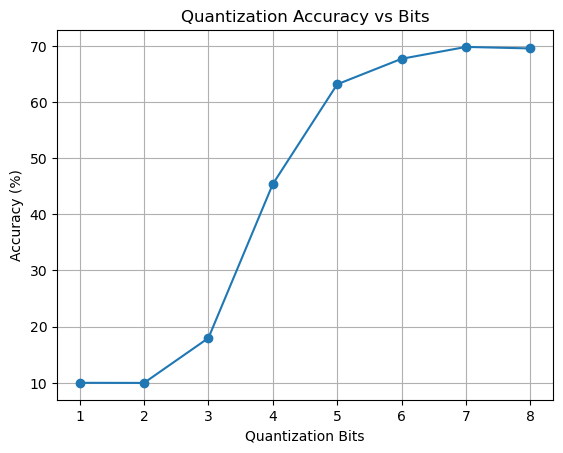

In [56]:
# Initialize an empty list to store the accuracies

accuracies = []

# Loop over the range of quantization bits
for num_bits in range(1, 9):
    save_model = QLeNet5_CIFAR_10()  
    save_model.load_state_dict(torch.load('LeNet5_CIFAR10.pth'))
    save_model.eval()
    full_accuracy = full_inference(save_model, cifar10_test_data)
    
    # Quantize the model
    save_model.quantize(num_bits=num_bits)
    save_model.eval()
    print(f'Quantization bit: {num_bits}')

    # Directly quantize the model using training data and then freeze it for inference
    direct_quantize(save_model, cifar10_test_data)
    save_model.freeze()

    # Perform quantized inference and store the accuracy
    quantized_accuracy = quantize_inference(save_model, cifar10_test_data)
    accuracies.append(quantized_accuracy)

    print(f'Full Model Accuracy: {full_accuracy}%')
    print(f'Quantized Model Accuracy ({num_bits}-bit): {quantized_accuracy}%\n')

# Plotting the results
plt.plot(range(1, 9), accuracies, marker='o')
plt.xlabel('Quantization Bits')
plt.ylabel('Accuracy (%)')
plt.title('Quantization Accuracy vs Bits')
plt.grid(True)
plt.show()

MNIST

In [73]:
save_model = QLeNet5_MNIST()
# load the parameters
save_model.load_state_dict(torch.load('LeNet5_MNIST.pth'))

save_model.eval()
full_inference(save_model, test_data)

num_bits = 4
save_model.quantize(num_bits=num_bits)
save_model.eval()
print('Quantization bit: %d' % num_bits)

direct_quantize(save_model, test_data)
save_model.freeze()
quantize_inference(save_model, test_data)


Test set: Full Model Accuracy: 99%

Quantization bit: 4
direct quantization finish

Test set: Quant Model Accuracy: 97%



96.9


Test set: Full Model Accuracy: 99%

Quantization bit: 1
direct quantization finish

Test set: Quant Model Accuracy: 10%

Full Model Accuracy: None%
Quantized Model Accuracy (1-bit): 9.74%


Test set: Full Model Accuracy: 99%

Quantization bit: 2
direct quantization finish

Test set: Quant Model Accuracy: 10%

Full Model Accuracy: None%
Quantized Model Accuracy (2-bit): 10.5%


Test set: Full Model Accuracy: 99%

Quantization bit: 3
direct quantization finish

Test set: Quant Model Accuracy: 75%

Full Model Accuracy: None%
Quantized Model Accuracy (3-bit): 75.04%


Test set: Full Model Accuracy: 99%

Quantization bit: 4
direct quantization finish

Test set: Quant Model Accuracy: 97%

Full Model Accuracy: None%
Quantized Model Accuracy (4-bit): 96.78%


Test set: Full Model Accuracy: 99%

Quantization bit: 5
direct quantization finish

Test set: Quant Model Accuracy: 99%

Full Model Accuracy: None%
Quantized Model Accuracy (5-bit): 98.7%


Test set: Full Model Accuracy: 99%

Quantizatio

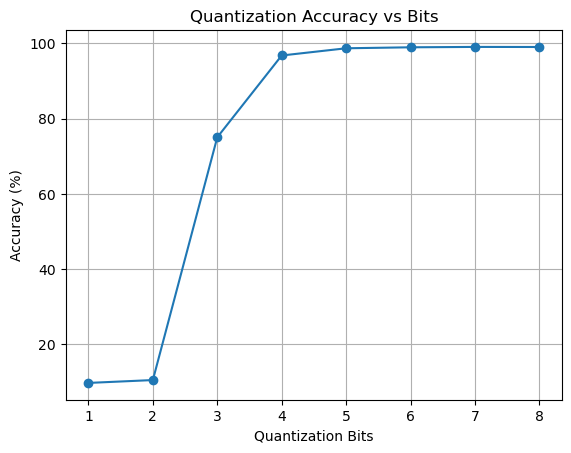

In [69]:
# Initialize an empty list to store the accuracies
save_model = QLeNet5_MNIST()
accuracies = []

# Loop over the range of quantization bits
for num_bits in range(1, 9):
    save_model = QLeNet5_MNIST() 
    save_model.load_state_dict(torch.load('LeNet5_MNIST.pth'))
    save_model.eval()
    full_accuracy = full_inference(save_model, test_data)
    
    # Quantize the model
    save_model.quantize(num_bits=num_bits)
    save_model.eval()
    print(f'Quantization bit: {num_bits}')

    # Directly quantize the model using training data and then freeze it for inference
    direct_quantize(save_model, test_data)
    save_model.freeze()

    # Perform quantized inference and store the accuracy
    quantized_accuracy = quantize_inference(save_model, test_data)
    accuracies.append(quantized_accuracy)

    print(f'Full Model Accuracy: {full_accuracy}%')
    print(f'Quantized Model Accuracy ({num_bits}-bit): {quantized_accuracy}%\n')

# Plotting the results
plt.plot(range(1, 9), accuracies, marker='o')
plt.xlabel('Quantization Bits')
plt.ylabel('Accuracy (%)')
plt.title('Quantization Accuracy vs Bits')
plt.grid(True)
plt.show()